In [163]:
%matplotlib inline

import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression
from keras.utils import plot_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from ggplot import ggplot, geom_line, geom_abline, aes
import matplotlib.pyplot as plt
import collections

from sklearn.manifold import TSNE

In [4]:
data = pandas.read_csv("data.csvvectors.csv", header=None, error_bad_lines=False)

Skipping line 299854: expected 56 fields, saw 57

Skipping line 724412: expected 56 fields, saw 58
Skipping line 730094: expected 56 fields, saw 58

Skipping line 838678: expected 56 fields, saw 57

/Users/hongee/Envs/cs145_project/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
filtered = data[data[55] == False]
filtered = filtered[filtered[53] != 0]

In [ ]:
test_size = 50000

In [152]:
filtered = filtered.sample(frac=1)
X = filtered.iloc[:,1:51]
y = filtered.iloc[:,52]
y_binary = numpy.array([ 1 if y0 > 0 else -1 for y0 in y ])

train_X = filtered.iloc[50000:,1:51]
train_y = filtered.iloc[50000:,52]
train_y_binary = [ 1 if y0 > 0 else -1 for y0 in train_y ]

test_X = filtered.iloc[:50000,1:51]
test_y = filtered.iloc[:50000,52]
test_y_binary = [ 1 if y0 > 0 else -1 for y0 in test_y ]

In [115]:
unique, counts = numpy.unique(y_binary, return_counts=True)
print numpy.asarray((unique, counts)).T

[[    -1 390671]
 [     1 317486]]


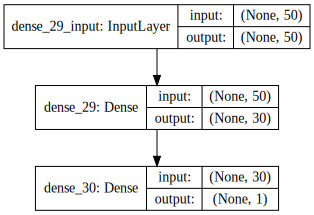

In [29]:
def basic_model():
    model = Sequential()
    model.add(Dense(30, input_dim=50, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

model = basic_model()
estimator = KerasClassifier(build_fn=basic_model, epochs=2, batch_size=20, verbose=True, )
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

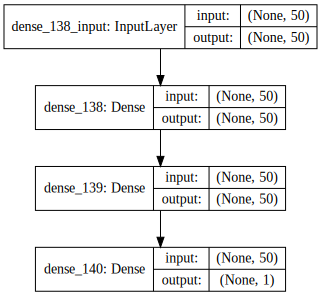

In [155]:
def deeper_model():
    model = Sequential()
    model.add(Dense(50, input_dim=50, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(50, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

model = deeper_model()
estimator = KerasRegressor(build_fn=basic_model, epochs=2, batch_size=200, verbose=True)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [107]:
log_reg = LogisticRegression(solver="sag")

In [161]:
seed = 34
numpy.random.seed(seed)
kfold = KFold(n_splits=5, random_state=seed)
nn_pred = []
accuracy_sum = 0
for train_index, test_index in kfold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    y_pred_binary = [ 1 if y0 > 0 else -1 for y0 in y_pred ]
    y_test_binary = [ 1 if y0 > 0 else -1 for y0 in y_test ]
    unique, counts = numpy.unique(y_pred_binary, return_counts=True)
    print numpy.asarray((unique, counts)).T
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    print "ACC: ", accuracy
    print "MSE: ", mean_squared_error(y_test, y_pred)
    
#results = cross_val_score(estimator, X, y_binary, cv=kfold)

Epoch 1/2
566525/566525 [==============================] - 6s 10us/step - loss: 8.0605e-04
Epoch 2/2
141632/141632 [==============================] - 1s 5us/step
[[    -1 102463]
 [     1  39169]]
ACC:  0.522798520108
MSE:  0.000774366466765
Epoch 1/2
566525/566525 [==============================] - 5s 9us/step - loss: 8.6068e-04
Epoch 2/2
141632/141632 [==============================] - 1s 5us/step
[[   -1 88188]
 [    1 53444]]
ACC:  0.513224412562
MSE:  0.000797351415288
Epoch 1/2
566526/566526 [==============================] - 5s 9us/step - loss: 7.9445e-04
Epoch 2/2
141631/141631 [==============================] - 1s 5us/step
[[    -1 125640]
 [     1  15991]]
ACC:  0.540277199201
MSE:  0.000791034472758
Epoch 1/2
566526/566526 [==============================] - 5s 9us/step - loss: 8.0823e-04
Epoch 2/2
141631/141631 [==============================] - 1s 5us/step
[[   -1 70180]
 [    1 71451]]
ACC:  0.499678742648
MSE:  0.000791082302092
Epoch 1/2
566526/566526 [==================

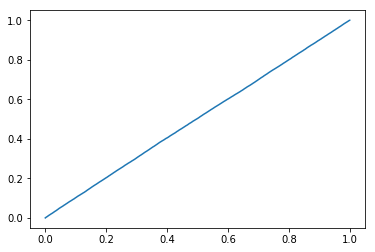

ROC AREA UNDER CURVE:  0.501994262596
ACC:  0.551672717568


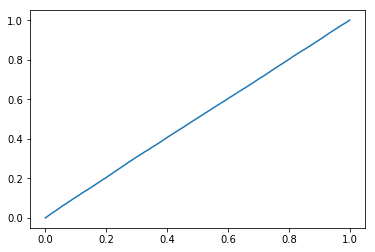

ROC AREA UNDER CURVE:  0.503681057466
ACC:  0.551672717568


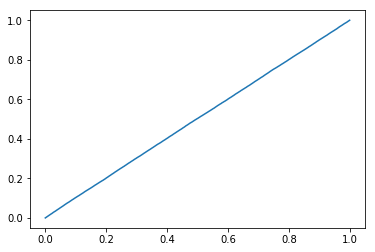

ROC AREA UNDER CURVE:  0.501617544
ACC:  0.551673155377


In [72]:
logreg_pred = []
for train_index, test_index in kfold.split(X, y_binary):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary[train_index], y_binary[test_index]
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_prob_pred = log_reg.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob_pred)
    plt.plot(fpr, tpr)
    plt.show()
    logreg_pred.append(y_pred)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob_pred)
    
    print "ROC AREA UNDER CURVE: ", auc
    print "ACC: ", acc

In [166]:
# X and y are already shuffled
sample_X = X[:500]
sample_y = y_binary[:500]

sample_X_embed = TSNE(n_components=2).fit_transform(sample_X)

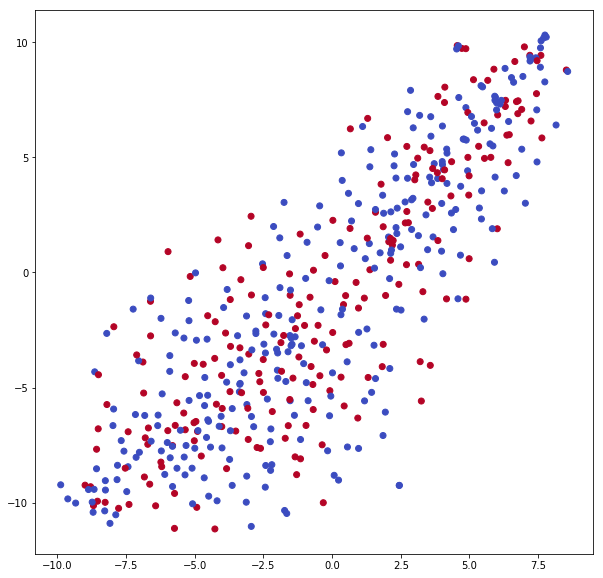

In [174]:
plt.figure(figsize=(10,10))
plt.scatter(sample_X_embed[:, 0], sample_X_embed[:, 1], c=sample_y, cmap=plt.cm.get_cmap("coolwarm", 10))
plt.show()

In [35]:
estimator.fit(train_X,train_y_binary)

Epoch 1/2
658157/658157 [==============================] - 30s 45us/step - loss: 0.2485
Epoch 2/2
658157/658157 [==============================] - 28s 42us/step - loss: 0.2485


In [36]:
pred_y_binary = estimator.predict(test_X)

50000/50000 [==============================] - 1s 21us/step


In [39]:
accuracy_score(test_y_binary, pred_y_binary)

0.53290000000000004

In [106]:
pred_y_binary = [ 1 if y > 0 else 0 for y in pred_y ]
test_y_binary = [ 1 if y > 0 else 0 for y in test_y ]

In [107]:
accuracy_score(test_y_binary, pred_y_binary)

0.51446000000000003

In [14]:
deeper_estimator.fit(train_X,train_y_binary)

Epoch 1/5
658157/658157 [==============================] - 28s 42us/step - loss: 7.9278e-04
Epoch 2/5
658157/658157 [==============================] - 26s 40us/step - loss: 7.9263e-04
Epoch 3/5
658157/658157 [==============================] - 28s 42us/step - loss: 7.9222e-04
Epoch 4/5
658157/658157 [==============================] - 27s 42us/step - loss: 7.9216e-04
Epoch 5/5
658157/658157 [==============================] - 26s 40us/step - loss: 7.9182e-04


In [133]:
pred_y_binary = estimator.predict(test_X)

print accuracy_score(test_y_binary, pred_y_binary)
unique, counts = numpy.unique(pred_y_binary, return_counts=True)
print numpy.asarray((unique, counts)).T


50000/50000 [==============================] - 0s 4us/step
0.54728
[[   -1 50000]]


In [19]:
seed = 27
numpy.random.seed(seed)
kfold = KFold(n_splits=5, random_state=seed)
results = cross_val_score(deeper_estimator, X, y, cv=kfold)

Epoch 1/5
566525/566525 [==============================] - 24s 43us/step - loss: 8.0661e-04
Epoch 2/5
566525/566525 [==============================] - 25s 44us/step - loss: 7.9577e-04
Epoch 3/5
566525/566525 [==============================] - 24s 43us/step - loss: 7.9476e-04
Epoch 4/5
566525/566525 [==============================] - 24s 43us/step - loss: 7.9448e-04
Epoch 5/5
141632/141632 [==============================] - 3s 23us/step
Epoch 1/5
566525/566525 [==============================] - 24s 42us/step - loss: 7.8868e-04
Epoch 2/5
566525/566525 [==============================] - 23s 41us/step - loss: 7.8829e-04
Epoch 3/5
566525/566525 [==============================] - 24s 42us/step - loss: 7.8801e-04
Epoch 4/5
566525/566525 [==============================] - 25s 44us/step - loss: 7.8782e-04
Epoch 5/5
141632/141632 [==============================] - 3s 24us/step
Epoch 1/5
566526/566526 [==============================] - 24s 43us/step - loss: 7.9864e-04
Epoch 2/5
566526/566526 [===

In [147]:
y

720806     -0.07
290816     0.025
626583   -0.0034
183985     0.005
925168         0
126826     -0.09
388729    -0.045
782805     -0.04
399533    -0.006
135850    0.0083
778873   -0.0081
500533   -0.0512
222821     0.005
277581   -0.0301
207198         0
456380      0.01
391466     0.045
394231   -0.0143
598835     -0.01
208215    -0.015
885903    0.0389
790342    -0.004
790026    -0.004
429842    -0.005
91952     0.0151
636879   -0.0084
879633     -0.01
355327     0.005
537247      0.01
926317    -0.024
           ...  
598244     -0.01
380693         0
756460   -0.0049
426832     0.015
194463    -0.005
835584     -0.01
386422    -0.155
358137         0
141838    -0.005
757292    0.0799
740625     0.013
924308         0
51466    -0.0156
297415   -0.0125
447444      0.01
809647     -0.01
182212     0.015
593322         0
546697         0
775763         0
450178     -0.03
611233      0.02
566728    0.0078
133651   -0.0252
132534   -0.0148
150812   -0.0099
275468    0.0012
413881    -0.0